In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import TidalPy
TidalPy.clear_cache(verbose=False)

from TidalPy.toolbox.conversions import days2rads, rads2days, semi_a2orbital_motion
from TidalPy.rheology.complex_compliance.compliance_models import maxwell, sundberg, andrade
from TidalPy.tides.multilayer.numerical_int import tidal_y_solver, tidal_y_solver_numba


R_Venus = 6050.0e3
M_Venus = 4.867e24
planet_bulk_density = M_Venus / ((4. / 3.) * np.pi * R_Venus**3)
venus_solar_day_freq = days2rads(116.75)
solar_day_forcing_frequency = venus_solar_day_freq

# Build Domain
N = 40
# Start at a radius slightly larger than 0.
radius_array_baseline = np.linspace(10., R_Venus, N)

# Rheology Inputs
alpha_baseline, zeta_baseline, andrade_critical_freq_baseline = 0.3, 1., days2rads(10000.)
rheology_inputs_baseline = (alpha_baseline, zeta_baseline, andrade_critical_freq_baseline)

# Integration parameters
int_rtol_scale = 1.
int_atol_scale = .01
use_numba_integrator = True

# Incompressibility Check
incomp_bulk = 1.0e18

In [2]:

# Build function inputs
N = 100
radius_array = np.linspace(0.1, R_Venus, N)

data = pd.read_csv('venus_data.csv')
radius_array = data['rad'].to_numpy()
density_array = data['rho'].to_numpy()
pressure_array = data['P'].to_numpy()
temperature_array = data['T'].to_numpy()
velocity_p = data['Vp'].to_numpy()
velocity_s = data['Vs'].to_numpy()
viscosity_array = data['visco'].to_numpy()
gravity_array = data['g'].to_numpy()

# Calculate shear and bulk modulus
shear_array = velocity_s**2 * density_array
bulk_array = velocity_p**2 * density_array - (4. / 3.) * shear_array

# Make any corrections
bulk_array[bulk_array < 0.] = 0.
shear_array[shear_array < 0.] = 0.

# Find the cut off between the inner core (if present), outer core, and mantle -- based on the shear velocity
oc_index = velocity_s == 0.
oc_radii = radius_array[oc_index]
cmb_radius = oc_radii[-1]
icb_radius = oc_radii[0]
mantle_index = radius_array > cmb_radius
ic_index = radius_array < icb_radius

complex_shear = maxwell(venus_solar_day_freq, shear_array**(-1), viscosity_array)**(-1)

function_inputs = (
    'solid_liquid_solid', radius_array, complex_shear, bulk_array, density_array, gravity_array,
    venus_solar_day_freq,
    (True, False, True), (True, True, True), (ic_index, oc_index, mantle_index)
)

function_kwargs = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'use_numba_integrator': True,
    'int_rtol': 1.e-9,
    'int_atol': 1.e-10,
    'planet_bulk_density': planet_bulk_density
}

function_kwargs_nb = (
     2, None, False, False, 1.e-9, 1.e-10, 1, False, True, planet_bulk_density, False
)

In [3]:
from TidalPy.utilities.graphics.multilayer import yplot

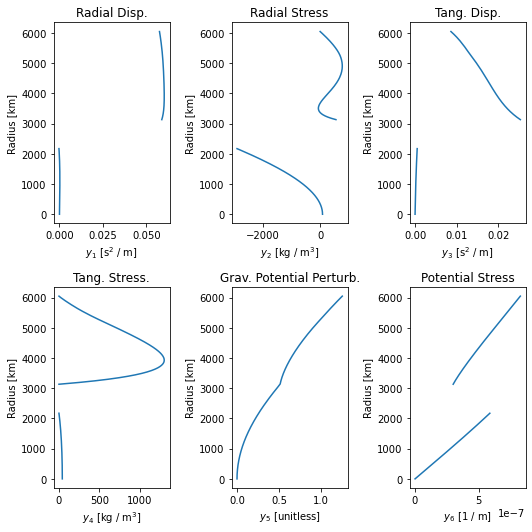

In [4]:
tidal_y = tidal_y_solver(*function_inputs, **function_kwargs)

_ = yplot(tidal_y, radius_array)

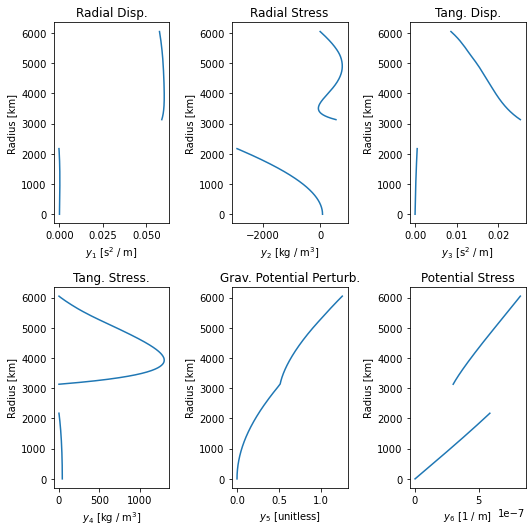

In [19]:
tidal_y = tidal_y_solver(*function_inputs, **function_kwargs)

_ = yplot(tidal_y, radius_array)

## Baseline

In [5]:
# Starting out 86.6ms


%timeit tidal_y_solver(*function_inputs, **function_kwargs)

86.5 ms ± 297 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%timeit tidal_y_solver_numba(*function_inputs, *function_kwargs_nb)

86.7 ms ± 636 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
